<a href="https://colab.research.google.com/github/nhwhite212/DealingwithDataSpring2021/blob/colab/G3_Citibike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
!sudo apt-get install python3-dev default-libmysqlclient-dev
!pip3 -q install mysqlclient
!pip3 -q install sql_magic
!pip3 -q install sqlalchemy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
The following NEW packages will be installed:
  default-libmysqlclient-dev libmysqlclient-dev
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 992 kB of archives.
After this operation, 6,023 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmysqlclient-dev amd64 5.7.32-0ubuntu0.18.04.1 [988 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 default-libmysqlclient-dev amd64 1.0.4 [3,736 B]
Fetched 992 kB in 1s (1,201 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This 

In [ ]:
# This gives information for each station that remains stable over time
url_stations = 'https://gbfs.citibikenyc.com/gbfs/en/station_information.json'

# This gives the live status of all the stations (e.g., bikes available etc)
url_status = 'https://gbfs.citibikenyc.com/gbfs/en/station_status.json'

In [ ]:
# We fetch for now just the time-invariant data
results = requests.get(url_stations).json() 

In [ ]:
# We only need a subset of the data in the JSON returned by the Citibike API, so we keep only what we need
data = results["data"]["stations"]

In [ ]:
# We will not be using dataframes for this insertion task. (See the G2 notebook if you want to use Pandas)
# We just put the data in a dataframe to understand what is going on.
import pandas as pd
df = pd.DataFrame(data)
df.head(5)

,legacy_id,region_id,name,has_kiosk,station_type,capacity,rental_url,external_id,eightd_has_key_dispenser,station_id,lat,eightd_station_services,lon,short_name,rental_methods,electric_bike_surcharge_waiver
0,72,71,W 52 St & 11 Ave,True,classic,55,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,66db237e-0aca-11e7-82f6-3863bb44ef7c,False,72,40.767272,[],-73.993929,6926.01,"[KEY, CREDITCARD]",False
1,79,71,Franklin St & W Broadway,True,classic,33,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,66db269c-0aca-11e7-82f6-3863bb44ef7c,False,79,40.719116,[],-74.006667,5430.08,"[KEY, CREDITCARD]",False
2,82,71,St James Pl & Pearl St,True,classic,27,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,66db277a-0aca-11e7-82f6-3863bb44ef7c,False,82,40.711174,[],-74.000165,5167.06,"[KEY, CREDITCARD]",False
3,83,71,Atlantic Ave & Fort Greene Pl,True,classic,62,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,66db281e-0aca-11e7-82f6-3863bb44ef7c,False,83,40.683826,[],-73.976323,4354.07,"[KEY, CREDITCARD]",False
4,116,71,W 17 St & 8 Ave,True,classic,50,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,66db28b5-0aca-11e7-82f6-3863bb44ef7c,False,116,40.741776,[],-74.001497,6148.02,"[KEY, CREDITCARD]",False


In [ ]:
# Now, let's connect to our database, where we will store our data.

from sqlalchemy import create_engine
#
# Note, the user can use their own userid and database
# i.e DealingS21GBx   where x is your team number...

conn_string_big = 'mysql://{user}:{password}@{host}/'.format(
    user='DealingS21',
    password='DealingS21!!',
    host='bigdata.stern.nyu.edu',
    port=3306,
    db='DealingS21',
    encoding='utf-8')


engine_bigdata = create_engine(conn_string_big)


In [ ]:
!sudo pip -q install sql_magic

In [ ]:
%reload_ext sql_magic

In [ ]:
%config SQL.conn_name='engine_bigdata'


In [ ]:
from sqlalchemy import create_engine

In [ ]:
%reload_ext sql_magic

In [ ]:
%config SQL.conn_name = 'engine_bigdata'

In [ ]:
%%read_sql
show databases

Query started at 10:49:03 PM UTC; Query executed in 0.03 m

,Database
0,information_schema
1,DealingS21
2,citibike


In [ ]:
# This will be the name of our database.
db_name = 'citibike'

In [ ]:
# Just bookkeeping. Drop the database if it is already there
create_db_query = "DROP DATABASE IF EXISTS {db}".format(db=db_name)
engine.execute(create_db_query)

NameError: ignored

In [ ]:
# Run a query to create a database that will hold the data
create_db_query = "CREATE DATABASE IF NOT EXISTS {db} DEFAULT CHARACTER SET 'utf8'".format(db=db_name)

# Create a database
engine_bigdata.execute(create_db_query)

In [ ]:
# Create the two tables. One for storing the time-invariant station data
# and another table to store the time-varying station status data
table_name = 'Stations'
create_table_query = '''CREATE TABLE IF NOT EXISTS {db}.{table} 
                                (station_id int, 
                                name varchar(250), 
                                capacity int,
                                lat float,
                                lon float,
                                region_id int,
                                short_name varchar(250),
                                rental_url varchar(250),
                                eightd_has_key_dispenser bool,
                                PRIMARY KEY(station_id)
                                )'''.format(db=db_name, table=table_name)
engine_bigdata.execute(create_table_query)

In [ ]:
results = requests.get(url_stations).json() 
data = results["data"]["stations"]
data[0]

{'capacity': 55,
 'eightd_has_key_dispenser': False,
 'eightd_station_services': [],
 'electric_bike_surcharge_waiver': False,
 'external_id': '66db237e-0aca-11e7-82f6-3863bb44ef7c',
 'has_kiosk': True,
 'lat': 40.76727216,
 'legacy_id': '72',
 'lon': -73.99392888,
 'name': 'W 52 St & 11 Ave',
 'region_id': '71',
 'rental_methods': ['KEY', 'CREDITCARD'],
 'rental_url': 'http://app.citibikenyc.com/S6Lr/IBV092JufD?station_id=72',
 'short_name': '6926.01',
 'station_id': '72',
 'station_type': 'classic'}

In [ ]:
# We fetch for now just the time-invariant data
# Notice that we have the INSERT IGNORE so that even when we add the same entry
# again, we do not get an error that the line exists. We do get warnings
# but this is expected

table_name = 'Stations'
query_template = '''INSERT IGNORE INTO {db}.{table}(station_id, 
                                        name,
                                        capacity, 
                                        lat, 
                                        lon,
                                        region_id,
                                        short_name,
                                        rental_url,
                                        eightd_has_key_dispenser) 
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)'''.format(db=db_name, table=table_name)

for entry in data:
    station_id = int(entry['station_id'])
    name = entry['name']
    capacity = entry['capacity']
    lat = entry['lat']
    lon = entry['lon']
    region_id = entry.get('region_id')
    short_name = entry['short_name']
    rental_url = entry['rental_url']
    eightd_has_key_dispenser = entry['eightd_has_key_dispenser']
                       
    print("Inserting station", station_id, "at", name)
    query_parameters = (station_id, name, capacity, lat, lon,
                        region_id, short_name, rental_url, eightd_has_key_dispenser)
    engine_bigdata.execute(query_template, query_parameters)


Inserting station 72 at W 52 St & 11 Ave
Inserting station 79 at Franklin St & W Broadway
Inserting station 82 at St James Pl & Pearl St
Inserting station 83 at Atlantic Ave & Fort Greene Pl
Inserting station 116 at W 17 St & 8 Ave
Inserting station 119 at Park Ave & St Edwards St
Inserting station 120 at Lexington Ave & Classon Ave
Inserting station 127 at Barrow St & Hudson St
Inserting station 128 at MacDougal St & Prince St
Inserting station 143 at Clinton St & Joralemon St
Inserting station 144 at Nassau St & Navy St
Inserting station 146 at Hudson St & Reade St
Inserting station 150 at E 2 St & Avenue C
Inserting station 151 at Cleveland Pl & Spring St
Inserting station 152 at Warren St & W Broadway
Inserting station 157 at Henry St & Atlantic Ave
Inserting station 161 at LaGuardia Pl & W 3 St
Inserting station 164 at E 47 St & 2 Ave
Inserting station 168 at W 18 St & 6 Ave
Inserting station 173 at Broadway & W 49 St
Inserting station 174 at E 25 St & 1 Ave
Inserting station 212 

In [ ]:
check = pd.read_sql("SELECT * FROM citibike.Stations", con=engine_bigdata)
check

,station_id,name,capacity,lat,lon,region_id,short_name,rental_url,eightd_has_key_dispenser
0,72,W 52 St & 11 Ave,55,40.7673,-73.9939,71,6926.01,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
1,79,Franklin St & W Broadway,33,40.7191,-74.0067,71,5430.08,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
2,82,St James Pl & Pearl St,27,40.7112,-74.0002,71,5167.06,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
3,83,Atlantic Ave & Fort Greene Pl,62,40.6838,-73.9763,71,4354.07,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
4,116,W 17 St & 8 Ave,50,40.7418,-74.0015,71,6148.02,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
...,...,...,...,...,...,...,...,...,...
1282,4327,21 St & 21 Ave,0,40.7825,-73.9145,71,7314.03,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
1283,4328,W 167 St & St. Nicholas Ave,27,40.8401,-73.9395,71,8206.05,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
1284,4329,35 St & 30 Ave,29,40.7655,-73.9181,71,6887.03,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
1285,4331,48 St & 37 Ave,0,40.7516,-73.9150,71,6435.02,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0


### plot the location of the stations, use the lon and lat and circles of size 10

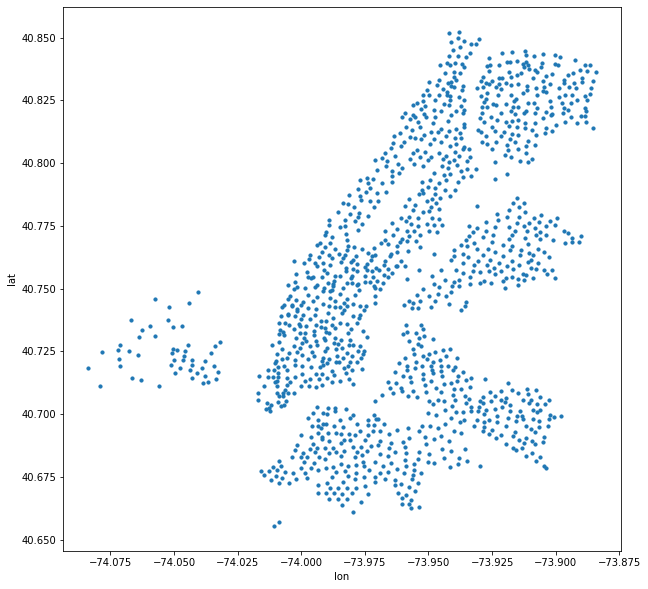

In [ ]:
%matplotlib inline
check.plot(kind='scatter', x='lon', y='lat', s=10, figsize=(10,10))

In [ ]:
# Create the time-varying table
table_name = 'Status'
create_table_query = '''CREATE TABLE IF NOT EXISTS {db}.{table} 
                                (station_id int, 
                                last_reported datetime,
                                num_bikes_available int,
                                num_bikes_disabled int,
                                num_docks_available int,
                                num_docks_disabled int,
                                is_installed bool,
                                is_renting bool,
                                is_returning bool,
                                eightd_has_available_keys bool,
                                PRIMARY KEY(station_id, last_reported)
                                )'''.format(db=db_name, table=table_name)
engine_bigdata.execute(create_table_query)

In [ ]:
results = requests.get(url_status).json() 
data = results["data"]["stations"]
data[0]

{'eightd_has_available_keys': False,
 'is_installed': 1,
 'is_renting': 1,
 'is_returning': 1,
 'last_reported': 1610837437,
 'legacy_id': '72',
 'num_bikes_available': 20,
 'num_bikes_disabled': 0,
 'num_docks_available': 35,
 'num_docks_disabled': 0,
 'num_ebikes_available': 1,
 'station_id': '72',
 'station_status': 'active'}

In [ ]:
# Now we fetch the data about the time varying elements of the citibike stations
from datetime import datetime

table_name = 'Status'
query_template = '''INSERT IGNORE INTO {db}.{table}(station_id, 
                                            num_bikes_available,
                                            num_bikes_disabled,
                                            num_docks_available,
                                            num_docks_disabled,
                                            is_installed,
                                            is_renting,
                                            is_returning,
                                            last_reported,
                                            eightd_has_available_keys) 
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)'''.format(db=db_name, table=table_name)

for entry in data:
    print(entry)
    station_id = int(entry['station_id'])
    num_bikes_available = entry['num_bikes_available']
    num_bikes_disabled = entry['num_bikes_disabled']
    num_docks_available = entry['num_docks_available']
    num_docks_disabled = entry['num_docks_disabled']
    is_installed = entry['is_installed']
    is_renting = entry['is_renting']
    is_returning = entry['is_returning']
    last_reported = datetime.fromtimestamp(entry['last_reported']) 
    eightd_has_available_keys = entry['eightd_has_available_keys']
                       
    print("Inserting station", station_id)
    query_parameters = (station_id, num_bikes_available, num_bikes_disabled,
                        num_docks_available, num_docks_disabled, is_installed, is_renting,
                        is_returning, last_reported, eightd_has_available_keys)
    engine_bigdata.execute(query_template, query_parameters)



{'num_bikes_disabled': 0, 'num_docks_available': 35, 'num_bikes_available': 20, 'is_returning': 1, 'num_ebikes_available': 1, 'last_reported': 1610837437, 'is_installed': 1, 'num_docks_disabled': 0, 'legacy_id': '72', 'station_status': 'active', 'eightd_has_available_keys': False, 'is_renting': 1, 'station_id': '72'}
Inserting station 72
{'num_bikes_disabled': 1, 'num_docks_available': 3, 'num_bikes_available': 29, 'is_returning': 1, 'num_ebikes_available': 2, 'last_reported': 1610836009, 'is_installed': 1, 'num_docks_disabled': 0, 'legacy_id': '79', 'station_status': 'active', 'eightd_has_available_keys': False, 'is_renting': 1, 'station_id': '79'}
Inserting station 79
{'num_bikes_disabled': 3, 'num_docks_available': 14, 'num_bikes_available': 10, 'is_returning': 1, 'num_ebikes_available': 0, 'last_reported': 1610837184, 'is_installed': 1, 'num_docks_disabled': 0, 'legacy_id': '82', 'station_status': 'active', 'eightd_has_available_keys': False, 'is_renting': 1, 'station_id': '82'}
In

In [ ]:
check = pd.read_sql("SELECT * FROM citibike.Status", con=engine_bigdata)
check


,station_id,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys
0,72,2021-01-16 22:50:37,20,0,35,0,1,1,1,0
1,79,2021-01-16 22:26:49,29,1,3,0,1,1,1,0
2,82,2021-01-16 22:46:24,10,3,14,0,1,1,1,0
3,83,2021-01-16 22:49:45,54,1,7,0,1,1,1,0
4,116,2021-01-16 22:50:52,16,2,32,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1282,4327,1970-01-02 00:00:00,0,0,0,0,0,0,0,0
1283,4328,2021-01-16 21:14:20,1,1,25,0,1,1,1,0
1284,4329,2021-01-16 22:13:14,7,0,22,0,1,1,1,0
1285,4331,1970-01-02 00:00:00,0,0,0,0,0,0,0,0


In [ ]:
con.close()